# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
!pip install cartopy xarray matplotlib netCDF4 torch

  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached xarray-2025.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached netCDF4-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached shapely-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached pyproj-3.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached cftime-1.6.4.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_r

In [2]:
import helper_functions
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/notebooks/helper_functions.py'>

## Data Loading & Preprocessing

In [3]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
print(ds.nbytes / 1e6, "MB")

z_temp = helper_functions.preprocessing(ds, ["thetao", "so"], [50, 300, 1000], "location", -1)
print(z_temp.shape)
X = z_temp.values
input_dimension = X.shape[1]
print(z_temp.nbytes / 1e6, "MB")
print(X.shape[1])

20554.545012 MB
(342, 167042)
457.026912 MB
167042


## Splitting

In [4]:
X = X.astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256, shuffle=False)

## The Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Shared encoder backbone
        self.encoder_shared = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
        )
        # Separate layers for mean and log-variance
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder_shared(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

## Loss Function

In [6]:
def vae_loss(x_recon, x, mu, logvar, beta=1e-3):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss.item(), kl_div.item()


In [7]:
def get_beta(epoch, total_epochs, max_beta=1):
    return max_beta * (epoch / total_epochs)

## Training Loop

In [8]:
def train(num_epochs: int, kl_beta=1e-3, kl_beta_max=1):

    torch.cuda.empty_cache()
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        
        kl_beta = get_beta(epoch, num_epochs, kl_beta_max) if kl_beta == -1 else kl_beta
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x = batch[0].to(device).float()
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta=kl_beta)

            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
    
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon, mu, logvar = model(x)
                loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta=kl_beta)

                running_val_loss += loss.item() * x.size(0)
    
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Recon: {recon:.4f} | KL: {kl:.4f}")

    return train_losses, val_losses

## Setup

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')

model = VariationalAutoencoder(input_dim=input_dimension, latent_dim=3).float().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainierbare Parameter: {total_params:,}")


num_epochs = 50
train_losses, val_losses = train(num_epochs,kl_beta=-1, kl_beta_max=2)

Training using device: cuda
Trainierbare Parameter: 171,487,112
Epoch 1/50 | Train Loss: 1.1774 | Val Loss: 1.0098 | Recon: 1.0098 | KL: 5.8140
Epoch 2/50 | Train Loss: 1.1584 | Val Loss: 0.9936 | Recon: 0.9936 | KL: 2.7962
Epoch 3/50 | Train Loss: 1.1390 | Val Loss: 0.9940 | Recon: 0.9940 | KL: 2.9074
Epoch 4/50 | Train Loss: 1.1198 | Val Loss: 0.9893 | Recon: 0.9893 | KL: 3.2430
Epoch 5/50 | Train Loss: 1.1034 | Val Loss: 0.9818 | Recon: 0.9818 | KL: 3.5897
Epoch 6/50 | Train Loss: 1.0835 | Val Loss: 0.9859 | Recon: 0.9859 | KL: 4.3097
Epoch 7/50 | Train Loss: 1.0639 | Val Loss: 0.9770 | Recon: 0.9770 | KL: 5.4585
Epoch 8/50 | Train Loss: 1.0450 | Val Loss: 0.9666 | Recon: 0.9666 | KL: 6.4017
Epoch 9/50 | Train Loss: 1.0250 | Val Loss: 0.9544 | Recon: 0.9544 | KL: 7.0642
Epoch 10/50 | Train Loss: 1.0066 | Val Loss: 0.9383 | Recon: 0.9383 | KL: 7.7581
Epoch 11/50 | Train Loss: 0.9893 | Val Loss: 0.9298 | Recon: 0.9298 | KL: 8.3116
Epoch 12/50 | Train Loss: 0.9705 | Val Loss: 0.9148 | 

## Evaluation

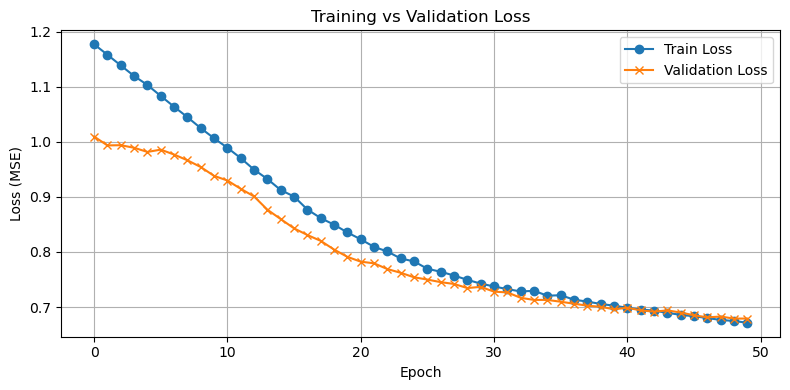

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

latents_mu = []
latents_logvar = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device).float()
        _, mu, logvar = model(x)
        latents_mu.append(mu.cpu())
        latents_logvar.append(logvar.cpu())

# Alles zusammenfügen
mu_all = torch.cat(latents_mu, dim=0)           # shape: (n_samples, latent_dim)
logvar_all = torch.cat(latents_logvar, dim=0)   # shape: (n_samples, latent_dim)

# Statistiken
mu_std = mu_all.std(dim=0)
logvar_mean = logvar_all.mean(dim=0)
logvar_std = logvar_all.std(dim=0)

# Ausgabe
print("Std of mu per latent dim:")
print(mu_std)

print("\nMean of logvar per latent dim:")
print(logvar_mean)

print("\nStd of logvar per latent dim:")
print(logvar_std)


Std of mu per latent dim:
tensor([2.5308, 2.8978, 2.5113])

Mean of logvar per latent dim:
tensor([-0.9054, -1.0602, -1.0387])

Std of logvar per latent dim:
tensor([0.2906, 0.2084, 0.3577])


## Reconstructing single samples

In [12]:
importlib.reload(helper_functions)
X_recon_all = helper_functions.reconstruct_in_batches(X, model, device, 64)

original_z = helper_functions.preprocessing(ds, ["thetao"], [50], "location")
reconstructed_z = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all)

helper_functions.plot_reconstruction_comparison(
    z_stack_original=original_z,
    z_stack_recon=reconstructed_z,
    time_indices=[0, 15, 80, 190],
    cmin=-2,
    cmax=2
)

TypeError: preprocessing() missing 1 required positional argument: 'interpolate'

## Clustering with K-Means

In [ ]:
from sklearn.cluster import KMeans
import torch

def get_latents_and_cluster(model, X, n_clusters=5, batch_size=512, device="cpu"):
    """
    Computes the latent representations (mu) for all inputs and clusters them using KMeans.

    Parameters:
    - model: Trained VariationalAutoencoder
    - X: Input data as a numpy array or torch.Tensor of shape (n_samples, input_dim)
    - n_clusters: Number of clusters for KMeans
    - batch_size: Batch size for efficient computation
    - device: Device to run the model on ("cpu" or "cuda")

    Returns:
    - latents: Tensor of shape (n_samples, latent_dim)
    - cluster_labels: Numpy array of shape (n_samples,) with cluster assignments
    """

    model.eval()
    model.to(device)

    if isinstance(X, torch.Tensor):
        X_tensor = X
    else:
        X_tensor = torch.tensor(X, dtype=torch.float32)

    X_tensor = X_tensor.to(device)
    latents = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            h = model.encoder_shared(batch)
            mu = model.mu_layer(h)
            latents.append(mu.cpu())

    latents = torch.cat(latents, dim=0)  # (n_samples, latent_dim)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latents.numpy())

    return latents, cluster_labels


In [ ]:
latents, labels= get_latents_and_cluster(model, X, n_clusters = 9, batch_size=16)
labels+=1
helper_functions.plot_cluster_timeline(z_temp, labels)

### Depth = 50

In [ ]:
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

In [ ]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

In [ ]:
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

In [ ]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

In [ ]:
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

In [ ]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)